### Library Imports



In [1]:
import os
import time
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    matthews_corrcoef, roc_auc_score, confusion_matrix, classification_report
)

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

try:
    from xgboost import XGBClassifier
    xgboost_lib_available = True
except Exception:
    xgboost_lib_available = False

from joblib import dump

plt.style.use('seaborn-v0_8')
pd.set_option('display.max_columns', 100)
SEED_VALUE = 42

### Dataset Loading
Below cell uses `kagglehub` to download the Breast Cancer dataset.

In [2]:
import kagglehub
import os
import pandas as pd

# Download dataset using KaggleHub
dataset_download_path = kagglehub.dataset_download("yasserh/breast-cancer-dataset")
print("Dataset path:", dataset_download_path)
print("Root contents:", os.listdir(dataset_download_path))

# Recursively find CSV files
found_csv_files = []
for root, dirs, files in os.walk(dataset_download_path):
    for f in files:
        if f.endswith(".csv"):
            found_csv_files.append(os.path.join(root, f))

print("CSV files found:")
for f in found_csv_files:
    print(f)

# Load the first CSV file found into a DataFrame 'data_frame'
if found_csv_files:
    data_frame = pd.read_csv(found_csv_files[0])
    print("\nDataFrame loaded successfully:")
    print(data_frame.head())
else:
    raise FileNotFoundError("No CSV files found in the downloaded dataset.")

# Drop ID column if present (not a feature)
if "id" in data_frame.columns:
    data_frame = data_frame.drop(columns=["id"])

Using Colab cache for faster access to the 'breast-cancer-dataset' dataset.
Dataset path: /kaggle/input/breast-cancer-dataset
Root contents: ['breast-cancer.csv']
CSV files found:
/kaggle/input/breast-cancer-dataset/breast-cancer.csv

DataFrame loaded successfully:
         id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42         20.38           77.58      386.1   
4  84358402         M        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960          

### Metadata and Initial Data Exploration
Below cell defines metadata for the project and performs a quick exploratory data analysis (EDA). It prints information about the dataset, including its name, source, number of samples, problem type, target column, and the distribution of target classes.

In [3]:
# Metadata
project_dataset_name = "Breast Cancer (Wisconsin)"
project_dataset_source = "https://www.kaggle.com/datasets/yasserh/breast-cancer-dataset"

# Explicitly set target column
target_column_name = "diagnosis"

if target_column_name not in data_frame.columns:
    raise KeyError(f"Target column '{target_column_name}' not found in dataset.")

print("\nMetadata:")
print("Dataset Name:", project_dataset_name)
print("Source:", project_dataset_source)
print("Number of Samples:", len(data_frame))
print("Problem Type:", "classification")
print("Target Column:", target_column_name)

print("\nClass distribution:")
print(data_frame[target_column_name].value_counts(dropna=False))

# Drop ID column if present
if "id" in data_frame.columns:
    data_frame = data_frame.drop(columns=["id"])

# Feature columns (drop target)
input_feature_columns = [c for c in data_frame.columns if c != target_column_name]

print("\nNumber of features:", len(input_feature_columns))


Metadata:
Dataset Name: Breast Cancer (Wisconsin)
Source: https://www.kaggle.com/datasets/yasserh/breast-cancer-dataset
Number of Samples: 569
Problem Type: classification
Target Column: diagnosis

Class distribution:
diagnosis
B    357
M    212
Name: count, dtype: int64

Number of features: 30


### Data Preprocessing and Splitting
Below cell handles data preprocessing and setting up preprocessing pipelines for each type. Finally, the data is split into training and testing sets using a stratified approach.

In [4]:
# Preprocessing
features = data_frame[input_feature_columns].copy()
labels = data_frame[target_column_name].copy()

# Map binary labels to {0,1}: 'M'->1, 'B'->0 if applicable
if labels.dtype == 'object':
    labels = labels.str.strip()
    mapping = {'M': 1, 'B': 0, 'malignant': 1, 'benign': 0}
    labels = labels.map(lambda v: mapping.get(v, v))

if not np.issubdtype(pd.Series(labels).dtype, np.number):
    labels, _ = pd.factorize(labels)

# Identify numeric/categorical features
numerical_features = features.select_dtypes(include=[np.number]).columns.tolist()
categorical_input_features = [c for c in features.columns if c not in numerical_features]

numerical_pipeline_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler(with_mean=True))
])

categorical_pipeline_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

data_preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_pipeline_transformer, numerical_features),
        ("cat", categorical_pipeline_transformer, categorical_input_features),
    ],
    remainder='drop'
)

# Stratified split
X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.2, stratify=labels, random_state=SEED_VALUE
)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

Train shape: (455, 30), Test shape: (114, 30)


In [5]:
# Combine X_test and y_test into a single DataFrame
test_data_combined = X_test.copy()
test_data_combined['diagnosis'] = y_test

# Save the combined DataFrame to a CSV file
test_data_combined.to_csv('test_data_with_target.csv', index=False)
print('test_data_with_target.csv has been saved')

test_data_with_target.csv has been saved


### Defining Model Pipelines
Below cell defines various models (Logistic Regression, Decision Tree, kNN, Naive Bayes, Random Forest, and XGBoost) each with a  Pipeline. Each pipeline includes the `data_preprocessor` defined earlier, ensuring consistent preprocessing across all models before the classifier is applied.

In [6]:
# Define model pipelines
model_pipelines = {}

model_pipelines["Logistic Regression"] = Pipeline(steps=[
    ("preprocess", data_preprocessor),
    ("clf", LogisticRegression(max_iter=1000, solver='lbfgs', random_state=SEED_VALUE))
])

model_pipelines["Decision Tree"] = Pipeline(steps=[
    ("preprocess", data_preprocessor),
    ("clf", DecisionTreeClassifier(random_state=SEED_VALUE))
])

model_pipelines["kNN"] = Pipeline(steps=[
    ("preprocess", data_preprocessor),
    ("clf", KNeighborsClassifier(n_neighbors=11))
])

model_pipelines["Naive Bayes (Gaussian)"] = Pipeline(steps=[
    ("preprocess", data_preprocessor),
    ("clf", GaussianNB())
])

model_pipelines["Random Forest"] = Pipeline(steps=[
    ("preprocess", data_preprocessor),
    ("clf", RandomForestClassifier(n_estimators=300, random_state=SEED_VALUE, n_jobs=-1))
])

if xgboost_lib_available:
    model_pipelines["XGBoost"] = Pipeline(steps=[
        ("preprocess", data_preprocessor),
        ("clf", XGBClassifier(
            n_estimators=300,
            learning_rate=0.1,
            max_depth=4,
            subsample=0.9,
            colsample_bytree=0.9,
            reg_lambda=1.0,
            random_state=SEED_VALUE,
            n_jobs=-1,
            eval_metric='logloss'
        ))
    ])
else:
    print("WARNING: xgboost is not available; install it to train XGBoost model.")

### Model Training and Evaluation
Below cell trains each defined machine learning model on the training data (`X_train`, `y_train`) and evaluates their performance on the test data (`X_test`, `y_test`). It defines a `compute_metrics` function to calculate common classification metrics (Accuracy, Precision, Recall, F1-Score, MCC, AUC) and stores the results in a DataFrame. The models are then sorted by F1-Score and Accuracy.

In [7]:
# Training & evaluation
def compute_metrics(y_true, y_pred, y_prob=None):
    metrics = {}
    average = 'binary' if len(np.unique(y_true)) == 2 else 'macro'
    metrics['Accuracy'] = accuracy_score(y_true, y_pred)
    metrics['Precision'] = precision_score(y_true, y_pred, average=average, zero_division=0)
    metrics['Recall'] = recall_score(y_true, y_pred, average=average, zero_division=0)
    metrics['F1'] = f1_score(y_true, y_pred, average=average, zero_division=0)
    metrics['MCC'] = matthews_corrcoef(y_true, y_pred)

    try:
        if y_prob is not None:
            # Binary or multi-class AUC
            if getattr(y_prob, 'ndim', 1) == 1:
                metrics['AUC'] = roc_auc_score(y_true, np.asarray(y_prob).ravel())
            else:
                metrics['AUC'] = roc_auc_score(y_true, y_prob, multi_class='ovr', average='macro')
        else:
            metrics['AUC'] = np.nan
    except Exception:
        metrics['AUC'] = np.nan

    return metrics

evaluation_results = []
fitted_model_pipelines = {}

for model_pipeline_name, current_pipeline in model_pipelines.items():
    t0 = time.time()
    current_pipeline.fit(X_train, y_train)
    fit_time = time.time() - t0

    predicted_labels = current_pipeline.predict(X_test)

    # Probabilities for AUC
    predicted_probabilities = None
    try:
        proba = current_pipeline.predict_proba(X_test)
        if proba is not None and hasattr(proba, 'shape') and len(proba.shape) == 2 and proba.shape[1] == 2:
            predicted_probabilities = proba[:, 1]
        else:
            predicted_probabilities = proba
    except Exception:
        try:
            y_score = current_pipeline.decision_function(X_test)
            from scipy.special import expit
            predicted_probabilities = expit(y_score) if getattr(y_score, 'ndim', 1) == 1 else expit(y_score)
        except Exception:
            predicted_probabilities = None

    model_metrics = compute_metrics(y_test, predicted_labels, predicted_probabilities)
    model_metrics['Model'] = model_pipeline_name
    model_metrics['Train Time (s)'] = round(fit_time, 3)
    evaluation_results.append(model_metrics)
    fitted_model_pipelines[model_pipeline_name] = current_pipeline

evaluation_metrics_df = pd.DataFrame(evaluation_results)
display_columns = ['Model','Accuracy','AUC','Precision','Recall','F1','MCC','Train Time (s)']
evaluation_metrics_df = evaluation_metrics_df[display_columns]
sorted_evaluation_metrics_df = evaluation_metrics_df.sort_values(by=['F1','Accuracy'], ascending=False).reset_index(drop=True)
sorted_evaluation_metrics_df

,Model,Accuracy,AUC,Precision,Recall,F1,MCC,Train Time (s)
0,Random Forest,0.973684,0.994378,1.000000,0.928571,0.962963,0.944155,1.786
1,XGBoost,0.973684,0.992725,1.000000,0.928571,0.962963,0.944155,3.030
2,Logistic Regression,0.964912,0.996032,0.975000,0.928571,0.951220,0.924518,0.043
3,kNN,0.947368,0.980489,0.973684,0.880952,0.925000,0.887244,0.011
4,Decision Tree,0.929825,0.924603,0.904762,0.904762,0.904762,0.849206,0.032
5,Naive Bayes (Gaussian),0.921053,0.989087,0.923077,0.857143,0.888889,0.829162,0.018


### Confusion Matrix and Classification Report for Best Model
Below cell identifies the top-performing model based on the evaluation metrics. It then generates and visualizes the confusion matrix for this best model on the test set, providing a clear breakdown of true positives, true negatives, false positives, and false negatives. A detailed classification report is also printed, showing per-class precision, recall, and f1-score.

Best model: Random Forest


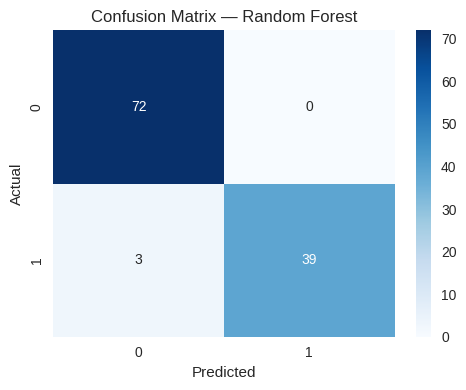


Classification Report — Random Forest
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        72
           1       1.00      0.93      0.96        42

    accuracy                           0.97       114
   macro avg       0.98      0.96      0.97       114
weighted avg       0.97      0.97      0.97       114



In [8]:
# Confusion matrix & classification report
top_performing_model_name = sorted_evaluation_metrics_df.iloc[0]['Model']
top_performing_model = fitted_model_pipelines[top_performing_model_name]
print("Best model:", top_performing_model_name)

predicted_labels_best_model = top_performing_model.predict(X_test)
confusion_matrix_results = confusion_matrix(y_test, predicted_labels_best_model)
class_labels = np.unique(y_test)

plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix_results, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title(f'Confusion Matrix — {top_performing_model_name}')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

print("\nClassification Report —", top_performing_model_name)
print(classification_report(y_test, predicted_labels_best_model, zero_division=0))

### Saving Trained Models
Below cell creates a directory named 'model' if it doesn't already exist. It then iterates through all the trained pipelines and saves each one as a `.pkl` file within this directory.

In [9]:
# Save trained pipelines into model
model_dir = Path('model')
model_dir.mkdir(exist_ok=True)

for model_pipeline_name, current_pipeline in fitted_model_pipelines.items():
    file_name = model_pipeline_name.lower().replace(' ', '_').replace('(', '').replace(')', '').replace('-', '')
    path = model_dir / f'{file_name}.pkl'
    dump(current_pipeline, path)
    print(f"Saved: {path}")

Saved: model/logistic_regression.pkl
Saved: model/decision_tree.pkl
Saved: model/knn.pkl
Saved: model/naive_bayes_gaussian.pkl
Saved: model/random_forest.pkl
Saved: model/xgboost.pkl
